In [1]:
import nashpy as nash

In [2]:
import networkx as nx

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

from IPython.display import HTML

In [6]:
import tqdm

In [7]:
from collections import deque

In [8]:
%matplotlib inline 

In [9]:
"""Code for implementation of a Moran process"""

import numpy as np
import numpy.typing as npt
import networkx as nx

from typing import Optional, Generator, Dict, Tuple

def score_all_individuals(
    A: npt.NDArray,
    population: npt.NDArray,
    beta
) -> npt.NDArray:
    """
    Return the scores of all individuals when they play against all other
    individuals in the population.

    Parameters
    ----------
    A : array
        a payoff matrix
    population : array
        the population
    w : float
        the selection strength

    Returns
    -------
    array
        the scores of every player in the population

    Raises
    ------
    ValueError
        If the payoff matrix A has a negative value. Currently only
        non negative valued matrices are supported.

    """
    if np.min(A) < 0:
        raise ValueError(
            "Only non negative valued payoff matrices are currently supported"
        )

    if interaction_graph_adjacency_matrix is None:
        interaction_graph_adjacency_matrix = get_complete_graph_adjacency_matrix(
            population=population
        )

    scores = []

    for i, player in enumerate(population):
        total = 0
        for j, opponent in enumerate(population):
            total += A[player, opponent]
        scores.append(total)

    return 1 - beta + beta * np.array(scores)


def update_population(
    population: npt.NDArray,
    scores: npt.NDArray,
    original_set_of_strategies: set,
) -> npt.NDArray:
    """
    Return the new population of all individuals given the scores of every
    individual.

    Birth is selected proportionally to scores.
    Death is uniformly random.

    Parameters
    ----------
    population : array
        the population
    scores : array
        the scores
    original_set_of_strategies: set
        the set of the strategies present in the initial population
    mutation_probability : float
        the probability of an individual selected to be copied mutates to
        another individual from the original set of strategies (even if they are
        no longer present in the population).
    replacement_stochastic_matrix: array
        Individual i chosen for replacement will replace individual j with
        probability P_{ij}.
        Default is None: this is equivalent to P_{ij} = 1 / N for all i, j.

    Returns
    -------
    array
        the next population
    """
    N = len(population)
    next_population = np.array(population)
    probabilities = scores / np.sum(scores)

    try:
        birth_index = np.random.choice(range(N), p=probabilities)
    except ValueError:
        birth_index = np.random.choice(range(N))

    death_index = np.random.randint(N)

    next_population[death_index] = next_population[birth_index]

    return next_population


def is_population_not_fixed(
    population: npt.NDArray,
    population_components: Tuple,
) -> bool:
    """
    Given a population vector and a set of population connected components this
    returns a boolean indicating if all individuals in each component are of the
    same type.
    This is used to check for fixation when using a replacement graph that may
    be disconnected.

    Parameters
    ----------
    population : array
        the population
    population_components : Tuple
        a tuple of sets containing node indices. Each set corresponds to a set
        of connected components.

    Returns
    -------
    bool
        True if the population is not yet fixed. True if the population is
        fixed (all individuals in all connected components have the same type).
    """
    return any(
        len(set(population[node] for node in component)) != 1
        for component in population_components
    )


def moran_process(
    A: npt.NDArray,
    initial_population: npt.NDArray,
    beta: float = 0,
) -> Generator[npt.NDArray, None, None]:
    """
    Return a generator of population across the Moran process. The last
    population is when only a single type of individual is present in the
    population.

    If an already fixed initial population is given then the generator will
    return that same initial population.

    Parameters
    ----------
    A : array
        a payoff matrix
    initial_population : array
        the initial population
    mutation_probability : float
        the probability of an individual selected to be copied mutates to
        another individual from the original set of strategies (even if they are
        no longer present in the population).
    replacement_stochastic_matrix: array
        Individual i chosen for replacement will replace individual j with
        probability P_{ij}.
        Default is None: this is equivalent to P_{ij} = 1 / N for all i, j.
    interaction_graph_adjacency_matrix : array
        the adjacency matrix for the interaction graph G: individuals of type i
        interact with individuals of type j count towards fitness iff G_{ij} =
        1.  Default is None: if so a complete graph is used -- this corresponds
        to all individuals interacting with each other (with no self
        interactions)

    Yields
    -------
    Generator
        The generations.
    """
    population = initial_population
    original_set_of_strategies = set(population)

    population_components = (set(range(len(population))),)

    if is_population_not_fixed(
        population=population, population_components=population_components
    ):
        while (mutation_probability > 0) or is_population_not_fixed(
            population=population, population_components=population_components
        ):
            scores = score_all_individuals(
                A=A,
                population=population,
                beta=beta,
            )

            population = update_population(
                population=population,
                scores=scores,
                original_set_of_strategies=original_set_of_strategies,            )

            yield population
    else:
        yield population

In [10]:
def score_all_individuals(
    A,
    population,
    beta,
):
    """
    Return the fitness of all individuals when they play against all other
    individuals in the population.

    Parameters
    ----------
    A : array
        a payoff matrix
    population : array
        the population
    beta : float
        the selection strength

    Returns
    -------
    array
        the fitness of every player in the population

    Raises
    ------
    ValueError
        If the payoff matrix A has a negative value. Currently only
        non negative valued matrices are supported.

    """
    if np.min(A) < 0:
        raise ValueError(
            "Only non negative valued payoff matrices are currently supported"
        )

    scores = []

    for i, player in enumerate(population):
        total = 0
        for j, opponent in enumerate(population):
            total += A[player, opponent]
        scores.append(total)

    return 1 - beta + beta * np.array(scores)

In [11]:
A = np.array([[3, 0], [5, 1]])

In [12]:
A = np.array([[3, 0], [5, 1]])

game = nash.Game(A)

In [13]:
np.random.seed(3)

N = 20

initial_population=[np.random.randint(0, 2) for _ in range(N)]

generations = game.moran_process(initial_population=initial_population)

# initial_population=[0, 0, 0, 1, 1, 1]

gens = list(generations)

In [14]:
def animate(i):
    axes.clear()
    gen = gens[i]

    G = nx.Graph()
    
    for j, typ in enumerate(gen):
        if typ == 0:
            color = 'tab:red'
        if typ == 1:
            color = 'tab:blue'
            
        G.add_node(j, color=color)
    
    colors = nx.get_node_attributes(G, "color")

    return nx.draw(G, pos, node_color=colors.values(), ax=axes)
    

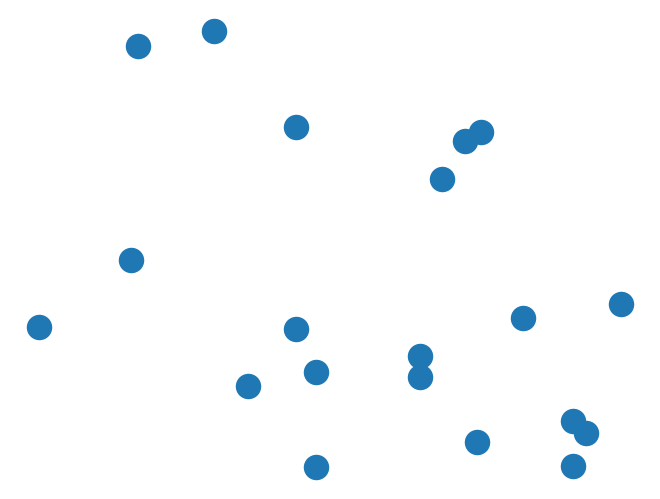

In [32]:
G = nx.Graph()

for j, _ in enumerate(initial_population):
    G.add_node(j)
    
pos = nx.random_layout(G, seed=14)

nx.draw(G, pos)

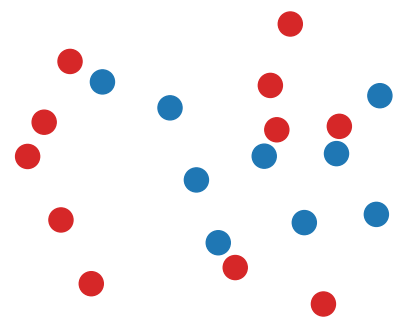

In [39]:
fig, axes = plt.subplots(figsize=(5, 4))

G = nx.Graph()

for j, _ in enumerate(initial_population):
    G.add_node(j)
    
pos = nx.random_layout(G, seed=10)

ani = FuncAnimation(fig, animate, frames=len(gens))

ani.save(filename="moran.html", writer="html")

HTML(ani.to_jshtml())

# writervideo = FFMpegWriter(fps=60) 

# ani.save('moran_process.mp4', writer=writervideo) 

In [26]:
N = 10

In [27]:
fixation_numerical = []

for i in tqdm.tqdm(range(1, N)):
    fixation_for_initial = 0
    
    k = N - i
    initial_population = [0 for _ in range(i)] + [1 for _ in range(k)]

    for num_of_simulations in range(10 ** 3):
        np.random.seed(num_of_simulations)
        generations = game.moran_process(initial_population=initial_population)

        last_population = tuple(generations)[-1]
    
        if 1 in last_population:
            fixation_for_initial += 1

    fixation_numerical.append(fixation_for_initial)

100%|█████████████████████████████████████████████| 9/9 [00:50<00:00,  5.57s/it]


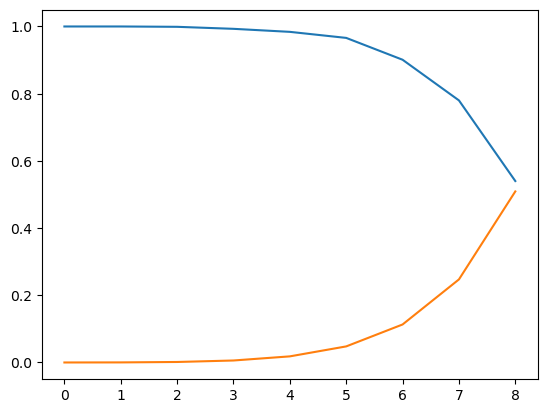

In [48]:
plt.plot(np.array(fixation_numerical) / 10 ** 3);

plt.plot([fixation_for_k_probability_moran_process(payoffs, 0.9999, N, k) for k in range(1, N)]);

In [20]:
def fitness_f_and_g(payoffs, k, beta, N):
    
    f = 1 - beta + (beta * (payoffs[0] * (k - 1) + payoffs[1] * (N - k))) / (N - 1)

    g = 1 - beta + (beta * (payoffs[2] * k + payoffs[3] * (N - k - 1))) / (N - 1)

    return f, g

In [21]:
def fixation_probability_moran_process(payoffs, beta, N):


    minus, plus = [], []
    for k in range(1, N):
        f, g = fitness_f_and_g(payoffs, k, beta, N)
        print(k, f, g)
        
        plus.append(f)
        minus.append(g)

    gammas = np.array(minus) / np.array(plus)

    return (
        float(1 / (1 + np.sum(np.cumprod(gammas)))),
    )
    

In [45]:
def fixation_for_k_probability_moran_process(payoffs, beta, N, k):


    minus, plus = [], []
    for i in range(1, N):
        f, g = fitness_f_and_g(payoffs, i, beta, N)
        
        plus.append(f)
        minus.append(g)

    gammas_den = np.array(minus) / np.array(plus)

    minus, plus = [], []
    for i in range(1, k):
        f, g = fitness_f_and_g(payoffs, i, beta, N)
        
        plus.append(f)
        minus.append(g)

    gammas_num = np.array(minus) / np.array(plus)

    return (
        float((1 + np.sum(np.cumprod(gammas_num))) / (1 + np.sum(np.cumprod(gammas_den)))),
    )
    

In [46]:
fixation_for_k_probability_moran_process(payoffs, 0.9, N, 5)

(0.021415189836396405,)

In [22]:
payoffs = np.array([3, 0, 5, 1])

In [23]:
fixation_probability_moran_process(payoffs, 1, N)

1 0.0 1.4444444444444444
2 0.3333333333333333 1.8888888888888888
3 0.6666666666666666 2.3333333333333335
4 1.0 2.7777777777777777
5 1.3333333333333333 3.2222222222222223
6 1.6666666666666667 3.6666666666666665
7 2.0 4.111111111111111
8 2.3333333333333335 4.555555555555555
9 2.6666666666666665 5.0


/var/folders/6v/fgr1d4wj08d2vtyc_bzn945m0000gn/T/ipykernel_9136/3036845630.py:12: RuntimeWarning: divide by zero encountered in divide
  gammas = np.array(minus) / np.array(plus)


(0.0,)

In [24]:
minus, plus = [], []
for k in range(1, N):
    f, g = fitness_f_and_g(payoffs, k, 1, N)
    print(k, f, g)
    
    plus.append(f)
    minus.append(g)

1 0.0 1.4444444444444444
2 0.3333333333333333 1.8888888888888888
3 0.6666666666666666 2.3333333333333335
4 1.0 2.7777777777777777
5 1.3333333333333333 3.2222222222222223
6 1.6666666666666667 3.6666666666666665
7 2.0 4.111111111111111
8 2.3333333333333335 4.555555555555555
9 2.6666666666666665 5.0


In [180]:
plus

[0.0,
 0.3333333333333333,
 0.6666666666666666,
 1.0,
 1.3333333333333333,
 1.6666666666666667,
 2.0,
 2.3333333333333335,
 2.6666666666666665]

In [181]:
minus

[1.4444444444444444,
 1.8888888888888888,
 2.3333333333333335,
 2.7777777777777777,
 3.2222222222222223,
 3.6666666666666665,
 4.111111111111111,
 4.555555555555555,
 5.0]